# Processing gravity data with Harmonica

1. Load the **gravity dataset**.
1. **Project** the data to plain coordinates.
1. Compute **gravity disturbance** by removing the normal gravity through Boule.
1. Load a **digital elevation model** (DEM) of the survey area.
1. Compute **Bouguer gravity disturbance** by forward modelling the topography with prisms.
1. **Interpolate** the Bouguer gravity disturbance onto a regular grid at a constant height through the **equivalent layer technique**.
1. Obtain the Bouguer gravity disturbance on a **profile** using the same equivalent layer.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyproj

import harmonica as hm
import verde as vd
import boule as bl
import pooch

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 130

In [3]:
data = hm.datasets.fetch_south_africa_gravity()
data

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


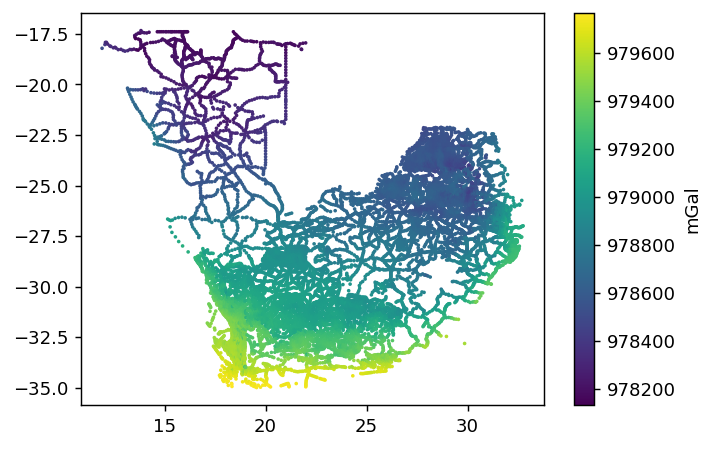

In [5]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")

In [6]:
region_deg = (25, 32, -27, -23)

inside = vd.inside((data.longitude, data.latitude, data.elevation), region_deg)

In [7]:
inside

0        False
1        False
2        False
3        False
4        False
         ...  
14554    False
14555    False
14556    False
14557    False
14558    False
Length: 14559, dtype: bool

In [8]:
data = data[inside]

In [9]:
data

,latitude,longitude,elevation,gravity
8848,-26.26334,25.01500,1230.16,978681.38
8849,-26.38713,25.01932,1297.00,978669.02
8850,-26.39667,25.02499,1304.84,978669.28
8851,-26.07668,25.04500,1165.24,978681.08
8852,-26.35001,25.07668,1262.47,978665.19
...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85
13175,-23.30000,31.52499,280.72,978798.55
13176,-23.19333,31.54832,245.67,978803.55
13177,-23.84833,31.57333,226.77,978808.44


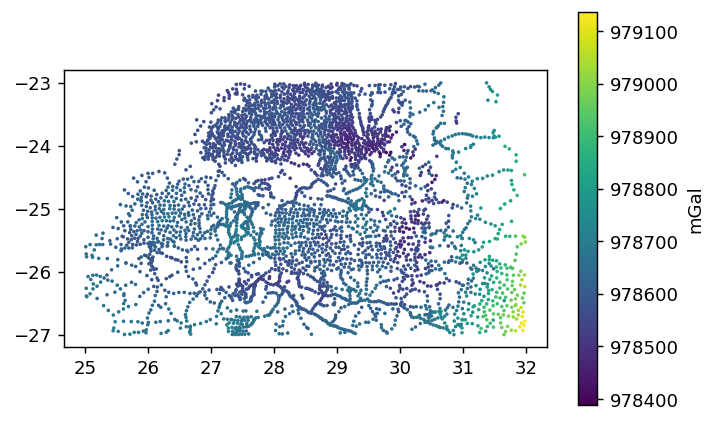

In [10]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=1)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")

In [11]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

easting, northing = projection(data.longitude.values, data.latitude.values)

In [12]:
easting

array([2526066.34109839, 2526502.58361662, 2527075.1519218 , ...,
       3185814.48211878, 3188340.04354955, 3168312.27071605])

In [13]:
northing

array([-2733051.96344292, -2746923.85974978, -2747993.53413991, ...,
       -2393566.88399165, -2465297.7243232 , -2372463.1178861 ])

In [14]:
data = data.assign(easting=easting)
data = data.assign(northing=northing)
data

,latitude,longitude,elevation,gravity,easting,northing
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06


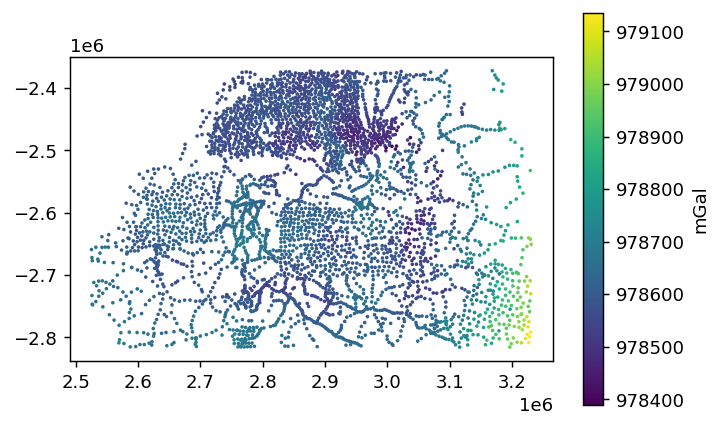

In [15]:
tmp = plt.scatter(data.easting, data.northing, c=data.gravity, s=1)
plt.gca().set_aspect('equal')
plt.colorbar(tmp, label="mGal")

In [16]:
ellipsoid = bl.WGS84
ellipsoid

Ellipsoid(name='WGS84', semimajor_axis=6378137, flattening=0.0033528106647474805, geocentric_grav_const=398600441800000.0, angular_velocity=7.292115e-05, long_name='World Geodetic System 1984', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')

In [17]:
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.elevation)

In [18]:
normal_gravity

8848     978664.725301
8849     978652.988542
8850     978651.255750
8851     978671.414340
8852     978660.974215
             ...      
13174    978785.393559
13175    978754.230966
13176    978758.068460
13177    978807.159627
13757    978733.156141
Length: 3877, dtype: float64

In [19]:
gravity_disturbance = data.gravity - normal_gravity

data = data.assign(gravity_disturbance=gravity_disturbance)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785
...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373


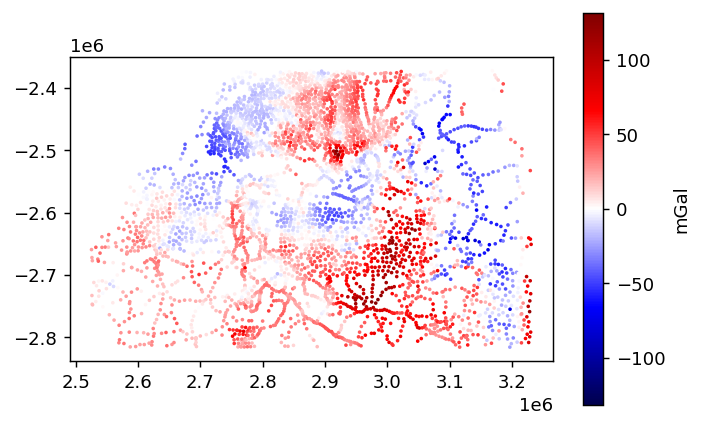

In [21]:
maxabs = vd.maxabs(data.gravity_disturbance)
tmp = plt.scatter(data.easting, data.northing, c=data.gravity_disturbance, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")

In [22]:
url = "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
fname = pooch.retrieve(url, known_hash=None, fname="bushveld_topography.nc")

In [23]:
fname

'/home/santi/.cache/pooch/bushveld_topography.nc'

In [24]:
topography = xr.load_dataset(fname)
topography

<xarray.Dataset>
Dimensions:    (latitude: 240, longitude: 419)
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Data variables:
    bedrock    (latitude, longitude) float64 1.257e+03 1.26e+03 ... 241.0 238.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1 Bedrock Relief
    GMT_version:  4.4.0
    node_offset:  0
    doi:          10.7289/V5C8276M

In [25]:
topography = topography.bedrock
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

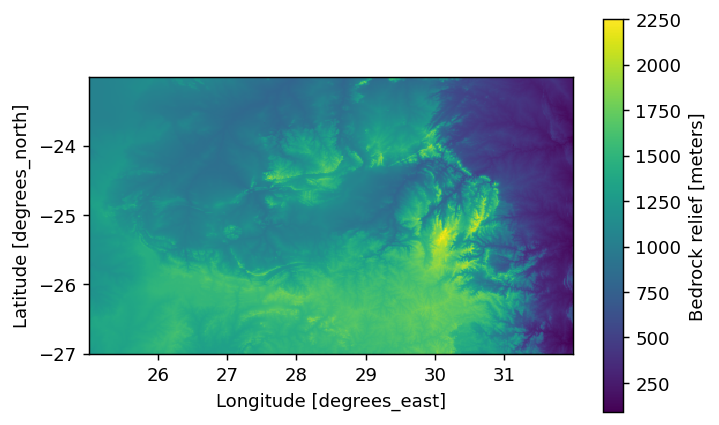

In [26]:
topography.plot()
plt.gca().set_aspect("equal")

In [27]:
topo_plain = vd.project_grid(topography, projection)
topo_plain

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.        , 1260.        , 1266.        , ...,  195.        ,
         201.        ,  425.        ],
       [1245.19963571, 1254.09981785, 1261.08318154, ...,  205.8170006 ,
         214.76709168,  375.83181545],
       [1255.63559308, 1257.86748839, 1267.76810468, ...,  200.19876741,
         231.43682566,  302.48459266],
       ...,
       [1029.03190101, 1031.        , 1033.03190101, ...,  248.06380202,
         242.03190101,  238.03190101],
       [1028.67199134, 1030.67199134, 1032.67199134, ...,  247.34398268,
         241.67199134,  237.67199134],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

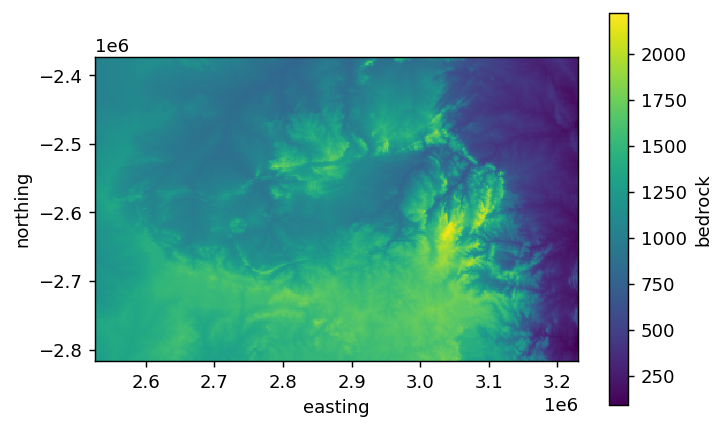

In [28]:
topo_plain.plot()
plt.gca().set_aspect("equal")

In [ ]:
hm.prism_layer

In [29]:
prisms_centers = (topo_plain.easting, topo_plain.northing)
surface = topo_plain.values
density = 2670 * np.ones_like(surface)

topo_prisms = hm.prism_layer(
    prisms_centers,
    surface,
    reference=0,
    properties={"density": density},
)
topo_prisms

<xarray.Dataset>
Dimensions:   (easting: 419, northing: 240)
Coordinates:
  * easting   (easting) float64 2.526e+06 2.528e+06 ... 3.228e+06 3.23e+06
  * northing  (northing) float64 -2.816e+06 -2.814e+06 ... -2.376e+06 -2.374e+06
    top       (northing, easting) float64 1.257e+03 1.26e+03 ... nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) float64 2.67e+03 2.67e+03 ... 2.67e+03
Attributes:
    coords_units:      meters
    properties_units:  SI

In [30]:
coordinates = (data.easting.values, data.northing.values, data.elevation.values)

result = topo_prisms.prism_layer.gravity(coordinates, field="g_z")

In [31]:
result

array([106.19254663, 120.6990796 , 128.83454757, ...,  24.13306068,
        23.58617757,   0.44729951])

In [32]:
bouguer_disturbance = data.gravity_disturbance - result
bouguer_disturbance

8848     -89.537848
8849    -104.667622
8850    -110.810297
8851    -112.746186
8852    -132.438823
            ...    
13174    -41.414814
13175     14.553012
13176     21.348479
13177    -22.305804
13757      1.166559
Name: gravity_disturbance, Length: 3877, dtype: float64

In [35]:
data = data.assign(bouguer_disturbance=bouguer_disturbance)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouger_disturbance,bouguer_disturbance
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699,-89.537848,-89.537848
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458,-104.667622,-104.667622
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250,-110.810297,-110.810297
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660,-112.746186,-112.746186
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785,-132.438823,-132.438823
...,...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559,-41.414814,-41.414814
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034,14.553012,14.553012
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540,21.348479,21.348479
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373,-22.305804,-22.305804


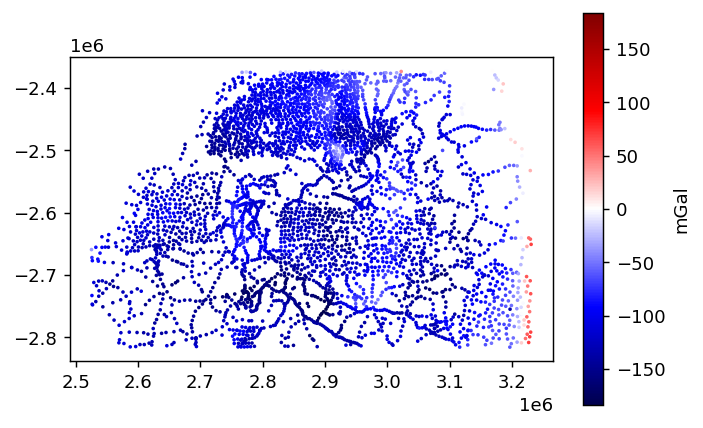

In [37]:
maxabs = vd.maxabs(data.bouguer_disturbance)
tmp = plt.scatter(data.easting, data.northing, c=data.bouguer_disturbance, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")


In [38]:
trend = vd.Trend(degree=2)
trend.fit(coordinates, data.bouguer_disturbance)

Trend(degree=2)

In [39]:
residuals = data.bouguer_disturbance - trend.predict(coordinates)

In [40]:
residuals

8848     20.664808
8849      5.367781
8850     -0.690107
8851     -1.928538
8852    -21.178332
           ...    
13174    16.012272
13175    57.102403
13176    60.057467
13177    33.118392
13757    38.453275
Name: bouguer_disturbance, Length: 3877, dtype: float64

In [41]:
data = data.assign(bouguer_residuals=residuals)
data

,latitude,longitude,elevation,gravity,easting,northing,gravity_disturbance,bouger_disturbance,bouguer_disturbance,bouguer_residuals
8848,-26.26334,25.01500,1230.16,978681.38,2.526066e+06,-2.733052e+06,16.654699,-89.537848,-89.537848,20.664808
8849,-26.38713,25.01932,1297.00,978669.02,2.526503e+06,-2.746924e+06,16.031458,-104.667622,-104.667622,5.367781
8850,-26.39667,25.02499,1304.84,978669.28,2.527075e+06,-2.747994e+06,18.024250,-110.810297,-110.810297,-0.690107
8851,-26.07668,25.04500,1165.24,978681.08,2.529096e+06,-2.712163e+06,9.665660,-112.746186,-112.746186,-1.928538
8852,-26.35001,25.07668,1262.47,978665.19,2.532295e+06,-2.742763e+06,4.215785,-132.438823,-132.438823,-21.178332
...,...,...,...,...,...,...,...,...,...,...
13174,-23.86333,31.51500,300.53,978776.85,3.182450e+06,-2.466945e+06,-8.543559,-41.414814,-41.414814,16.012272
13175,-23.30000,31.52499,280.72,978798.55,3.183459e+06,-2.405224e+06,44.319034,14.553012,14.553012,57.102403
13176,-23.19333,31.54832,245.67,978803.55,3.185814e+06,-2.393567e+06,45.481540,21.348479,21.348479,60.057467
13177,-23.84833,31.57333,226.77,978808.44,3.188340e+06,-2.465298e+06,1.280373,-22.305804,-22.305804,33.118392


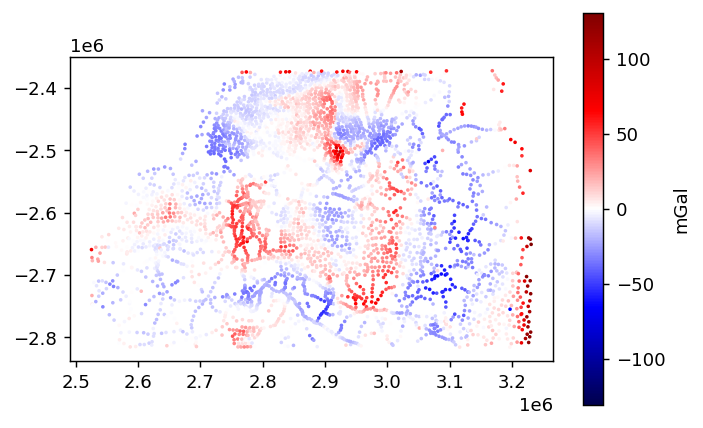

In [42]:
maxabs = vd.maxabs(data.bouguer_residuals)
tmp = plt.scatter(data.easting, data.northing, c=data.bouguer_residuals, s=1, vmin=-maxabs, vmax=maxabs, cmap="seismic")
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")

In [43]:
eql = hm.EQLHarmonic(damping=100, relative_depth=5000)
eql

EQLHarmonic(damping=100, relative_depth=5000)

In [44]:
eql.fit(coordinates, data.bouguer_residuals.values)

EQLHarmonic(damping=100, relative_depth=5000)

In [45]:
data.elevation.max()

2144.0

In [46]:
grid = eql.grid(
    upward=2200,
    region=region_deg,
    spacing=0.01,
    data_names=["bouguer_residuals"],
    dims=("latitude", "longitude"),
    projection=projection,
)

In [47]:
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 -1.22 -1.232 ... 11.6 11.49
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100, relative_depth=5000)

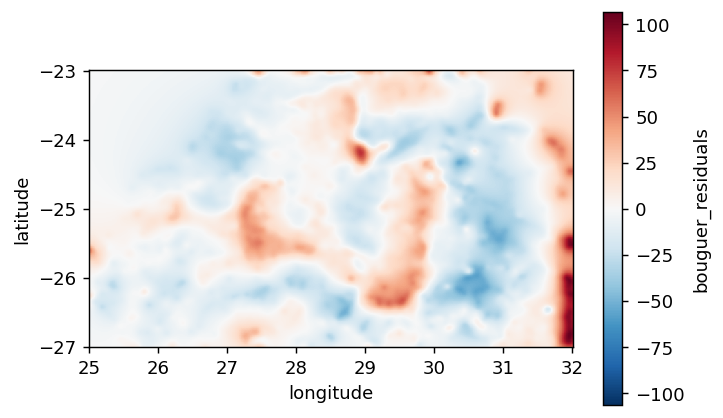

In [48]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")
plt.show()

In [49]:
grid = vd.convexhull_mask(data_coordinates=(data.longitude.values, data.latitude.values), grid=grid)
grid

<xarray.Dataset>
Dimensions:            (latitude: 401, longitude: 701)
Coordinates:
  * longitude          (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude           (latitude) float64 -27.0 -26.99 -26.98 ... -23.01 -23.0
    upward             (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    bouguer_residuals  (latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by EQLHarmonic(damping=100, relative_depth=5000)

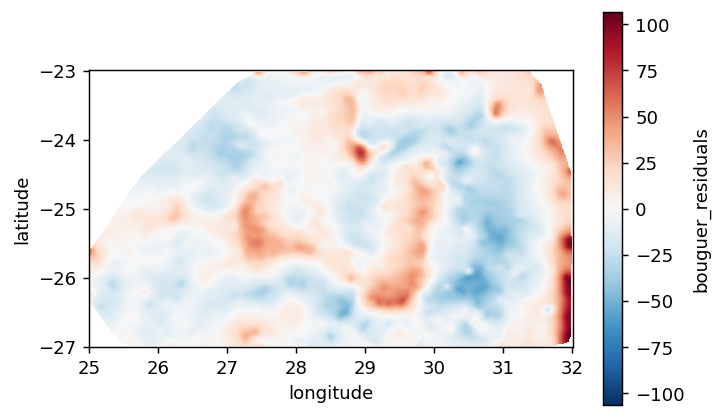

In [50]:
grid.bouguer_residuals.plot()
plt.gca().set_aspect("equal")

In [51]:
point1 = (26, -25)
point2 = (31, -25)

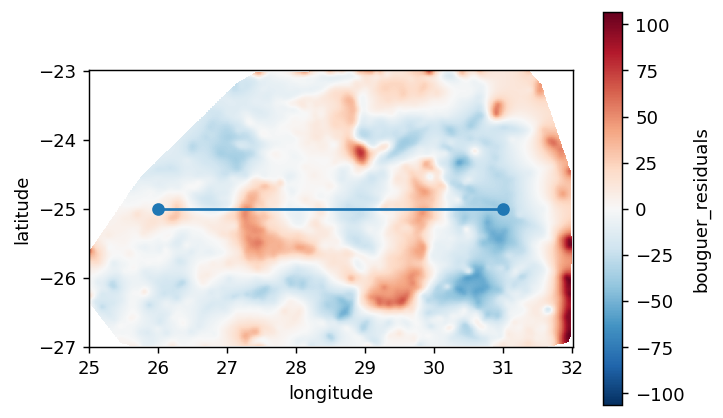

In [52]:
grid.bouguer_residuals.plot()
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], '-o')
plt.gca().set_aspect("equal")

In [53]:
profile = eql.profile(
    point1=point1,
    point2=point2,
    upward=2200,
    size=200,
    data_names=['bouguer_residuals'],
    projection=projection,
)
profile

,northing,easting,distance,upward,bouguer_residuals
0,-25.0,26.000000,0.000000,2200.0,5.678066
1,-25.0,26.025126,2537.237799,2200.0,6.183408
2,-25.0,26.050251,5074.475598,2200.0,6.737995
3,-25.0,26.075377,7611.713397,2200.0,7.349155
4,-25.0,26.100503,10148.951197,2200.0,8.159358
...,...,...,...,...,...
195,-25.0,30.899497,494761.370830,2200.0,-36.328428
196,-25.0,30.924623,497298.608629,2200.0,-36.466122
197,-25.0,30.949749,499835.846428,2200.0,-36.232926
198,-25.0,30.974874,502373.084227,2200.0,-35.689412


In [ ]:
plt.plot()